In [9]:
pip install plotly

  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/b8/f0/bcf716a8e070370d6598c92fcd328bd9ef8a9bda2c5562da5a835c66700b/plotly-5.23.0-py3-none-any.whl.metadata
  Obtaining dependency information for tenacity>=6.2.0 from https://files.pythonhosted.org/packages/b6/cb/b86984bed139586d01532a587464b5805f12e397594f19f931c4c2fbfa61/tenacity-9.0.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/17.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/17.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/17.3 MB 217.9 kB/s eta 0:01:20
   ---------------------------------------- 0.0/17.3 MB 326.8 kB/s eta 0:00:53
   ---------------------------------------- 0.1/17.3 MB 722.1 kB/s eta 0:00:24
    --------------------------------------- 0.3/17.3 MB 1.2 MB/s eta 0:00:15
    --------------------------------------- 0.4/17.3 MB 1.7 MB/s eta 0:00:11
   - -------------------------------------- 0.6/17.3 MB 2.0 MB/

In [4]:
pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/f1/13/de29b945fb28fc0c24159d3a83f1250c5232c1c9abac12434c7c3447e9cc/scikit_learn-1.5.1-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/4b/2c/ffbf7a134b9ab11a67b0cf0726453cedd9c5043a4fe7a35d1cefa9a1bcfb/threadpoolctl-3.5.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB 435.7 kB/s eta 0:00:26
   ---------------------------------------- 0.1/11.0 MB 980.4 kB/s eta 0:00:12
    --------------------------------------- 0.2/11.0 MB 1.4 MB/s eta 0:00:08
    --------------------------------------- 0.2/11.0 MB

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import json


json_open = open('02_imgae.json', 'r')
json_load = json.load(json_open)

# 画像を読み込む
image = cv2.imread('02_image.png', cv2.IMREAD_UNCHANGED)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGRからRGBに変換

# 1ピクセルごとに色を取得する
colors = []
xywh = json_load["frames"]["map00202_map2-2"]["frame"]
for y in range(xywh["y"], xywh["y"] + xywh["h"], 1):
    for x in range(xywh["x"], xywh["x"] + xywh["w"], 1):
        colors.append(image[y, x])

_colors = np.array(colors)

colors = np.unique(_colors, axis=0)
colors = np.delete(colors, np.where(colors[:,3] != 255), 0)  # 透明色を除外

colors_str = [f"rgb({color[2]}, {color[1]}, {color[0]})" for color in colors]


In [3]:


fig = px.scatter_3d(x=colors[:, 0], y=colors[:, 1], z=colors[:, 2], color=colors_str, color_discrete_map="identity")
fig.show()


In [4]:
import numpy as np

def bgr_to_lab(input_color):
    b, g, r = input_color[0] / 255.0, input_color[1] / 255.0, input_color[2] / 255.0

    r = r / 12.92 if r <= 0.04045 else ((r + 0.055) / 1.055) ** 2.4
    g = g / 12.92 if g <= 0.04045 else ((g + 0.055) / 1.055) ** 2.4
    b = b / 12.92 if b <= 0.04045 else ((b + 0.055) / 1.055) ** 2.4


    x = (r * 0.4124) + (g * 0.3576) + (b * 0.1805)
    y = (r * 0.2126) + (g * 0.7152) + (b * 0.0722)
    z = (r * 0.0193) + (g * 0.1192) + (b * 0.9505)

    x *= 100
    y *= 100
    z *= 100

    X_n = 95.0489
    Y_n = 100.0
    Z_n = 108.8840

    x = x / X_n
    y = y / Y_n
    z = z / Z_n

    delta = 6 / 29
    delta_3 = delta**3
    delta__2 = delta**-2

    def f(t):
        return t ** (1/3) if t > delta_3 else delta__2 * t / 3 + 4/29

    L = 116 * f(y) - 16
    a = 500 * (f(x) - f(y))
    b = 200 * (f(y) - f(z))

    return [L, a, b]

# RGB値の例
rgb = [128, 128, 128]
lab = bgr_to_lab(rgb)
print("L*a*b*値:", lab)



L*a*b*値: [53.58501345216902, 0.0011570453747333787, -0.0058762614675078595]


In [5]:
lab_color = np.array([bgr_to_lab(color) for color in colors])
# lab_color_str = [f"rgb({color[0]}, {color[1]}, {color[2]})" for color in lab_color]

fig = px.scatter_3d(x=lab_color[:, 0], y=lab_color[:, 1], z=lab_color[:, 2], color=colors_str, color_discrete_map="identity")
fig.show()


In [6]:

import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture

pd_data = pd.DataFrame(data=dict(R=lab_color[:, 2], G=lab_color[:, 1], B=lab_color[:, 0]))

dbscan = DBSCAN(eps=7, min_samples=2)
clusters = dbscan.fit(pd_data)
label = clusters.labels_

fig = px.scatter_3d(x=pd_data['R'], y=pd_data['G'], z=pd_data['B'], color=label, color_discrete_map="identity")
fig.show()
print(np.unique(label))

[-1  0  1  2]


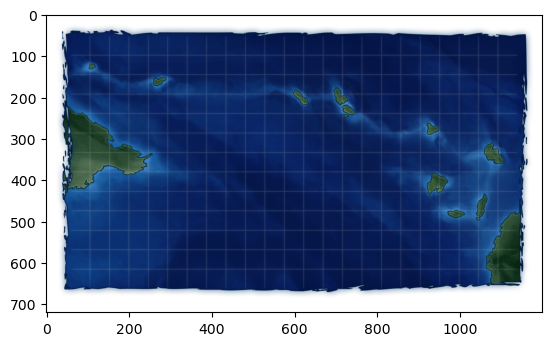

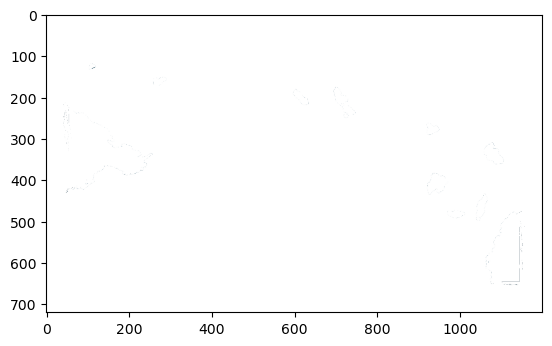

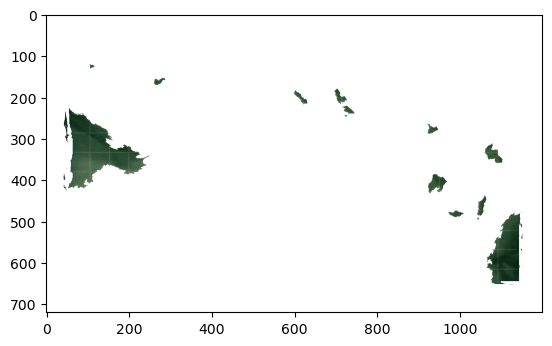

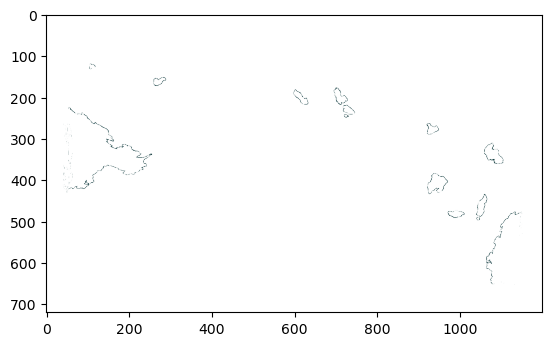

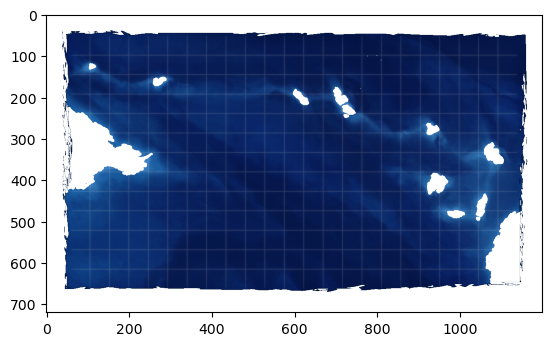

In [7]:

xywh = json_load["frames"]["map00202_map2-2"]["frame"]

image_list = [np.zeros((xywh["h"], xywh["w"], 4), np.uint8) for l in np.unique(label)]


image_rgba = image[xywh["y"]:xywh["y"] + xywh["h"], xywh["x"]:xywh["x"] + xywh["w"]][:, :, [2, 1, 0, 3]]
plt.imshow(image_rgba)
plt.show()

for i, l in enumerate(np.unique(label)):
    for y in range(xywh["y"], xywh["y"] + xywh["h"], 1):
        for x in range(xywh["x"], xywh["x"] + xywh["w"], 1):
            image_str = f'rgb({image[y, x][2]}, {image[y, x][1]}, {image[y, x][0]})'
            label_index = colors_str.index(image_str) if image_str in colors_str else -1
            label_bool = False if label_index == -1 else label[colors_str.index(image_str)] == l
            image_rgba = [image[y, x][2], image[y, x][1], image[y, x][0], 255] 
            image_list[i][y - xywh["y"], x - xywh["x"]] = image_rgba if label_bool else [255, 255, 255, 0]
            
    plt.imshow(image_list[i])
    plt.show()



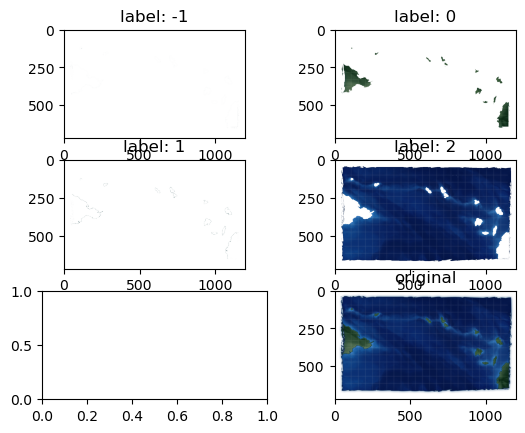

In [8]:

fig, ax = plt.subplots(3, 2)

for i, l in enumerate(np.unique(label)):
    ax[i // 2, i % 2].imshow(image_list[i])
    ax[i // 2, i % 2].set_title(f"label: {l}")

image_rgba = image[xywh["y"]:xywh["y"] + xywh["h"], xywh["x"]:xywh["x"] + xywh["w"]][:, :, [2, 1, 0, 3]]
ax[2, 1].imshow(image_rgba)
ax[2, 1].set_title("original")
plt.show()


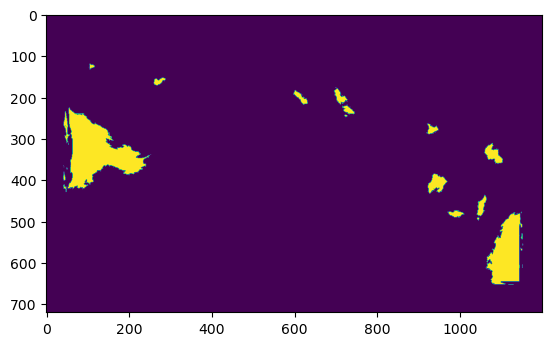

In [9]:
bicolor_u8 = np.zeros((xywh["h"], xywh["w"], 1), np.uint8)
label_index = np.where(np.unique(label) == 0)[0][0]

for y in range(xywh["y"], xywh["y"] + xywh["h"], 1):
    for x in range(xywh["x"], xywh["x"] + xywh["w"], 1):
        image_rgba = image_list[label_index][y - xywh["y"], x - xywh["x"]]
        bicolor_u8[y - xywh["y"], x - xywh["x"]] = [255] if image_rgba[3] == 255 else [0]

plt.imshow(bicolor_u8)

In [10]:
# # rand_color = (0xFC, 0xFF, 0xF5)
# rand_color = (0xCB, 0xDB, 0xD7)
# bound_color = [0x91 ,0xAA, 0xB4]
# # sea_color = [0x19, 0x34, 0x41]
# sea_color = [0x3E, 0x60, 0x6F]

# rand_color = (0xc0, 0xd6, 0xe2)
# bound_color = (0x3a, 0x42, 0x43)
# sea_color = [0x10, 0x21, 0x29]

# sea_color = [227,236,240]
# bound_color = [33,107,177]
# rand_color= [65,68,69]

# rand_color = [254, 249, 228]
# bound_color = [133, 169, 182]
# sea_color = 

# rand_color = [220, 211, 178]
# bound_color = [0x40, 0x6d, 0x72]
# sea_color = [0x47, 0x58, 0x5C]

# rand_color = [0xFB, 0xF8, 0xF3]
# bound_color = [84, 82, 81]
# sea_color = [0x90, 0xD8, 0xEF]


rand_color = [0xA1, 0xB4, 0xD4]
bound_color = [84, 82, 81]
sea_color = [0x45, 0x45, 0x45]

# rand_color = [0x7A, 0x90, 0x5F]
# bound_color = [84, 82, 81]
# sea_color = [0xFF, 0xFF, 0xFF]

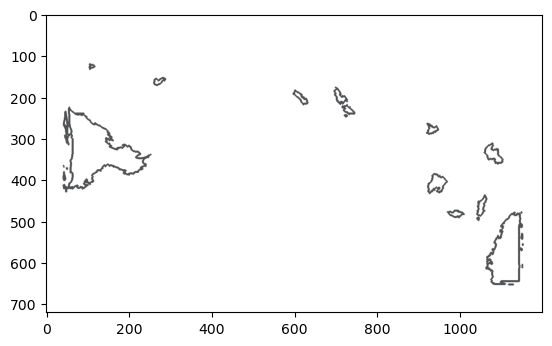

In [11]:
contours, hierarchy = cv2.findContours(bicolor_u8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_blank = bicolor = np.ones((xywh["h"], xywh["w"], 4), np.uint8)*255
img_contour_only = cv2.drawContours(img_blank, contours, -1, bound_color, 3)

plt.imshow(cv2.cvtColor(img_contour_only, cv2.COLOR_BGR2RGB))
plt.show()

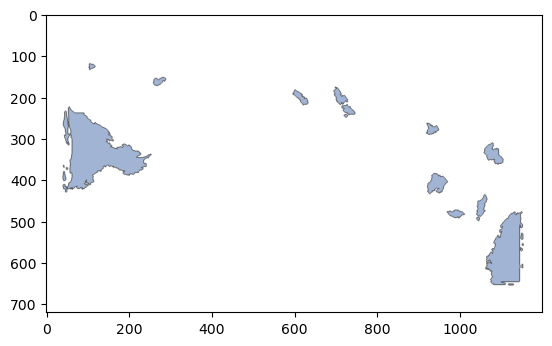

In [12]:

img2 = cv2.cvtColor(img_contour_only, cv2.COLOR_BGR2RGB)
for i in range(len(contours)):
    cnt = contours[i]
    img2 = cv2.drawContours(img2, [cnt], 0, rand_color, -1)

plt.imshow(img2)
plt.show()

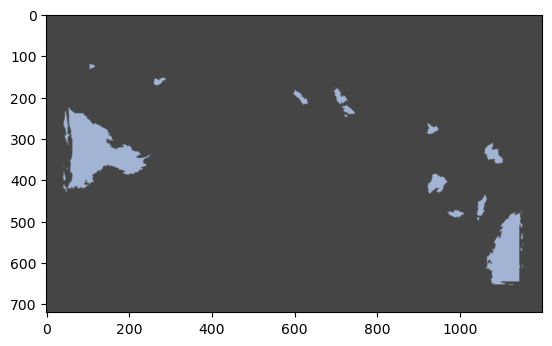

In [13]:
# bg = np.full((xywh["h"], xywh["w"], 3), sea_color)
img3 = np.zeros((xywh["h"], xywh["w"], 3), np.uint8)

# cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
# img3 = cv2.add(bg, img2)

for x in range(xywh["x"], xywh["x"] + xywh["w"], 1):
    for y in range(xywh["y"], xywh["y"] + xywh["h"], 1):
        image_rgba = img2[y - xywh["y"], x - xywh["x"]]
        img3[y - xywh["y"], x - xywh["x"]] = image_rgba[:3] if (image_rgba[0] != 255 or image_rgba[1] != 255 or image_rgba[2] != 255)  else sea_color



plt.imshow(img3)
plt.show()

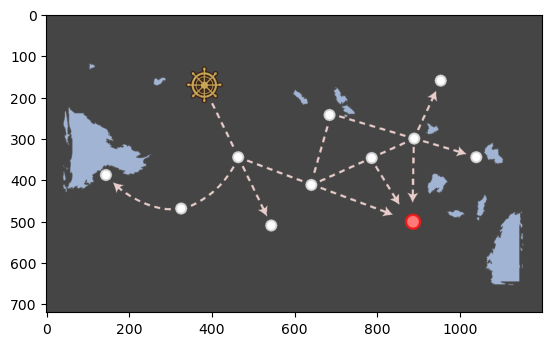

In [14]:
rxywh = json_load["frames"]["map00202_map2-2_point"]["frame"]

for x in range(rxywh["x"], rxywh["x"] + rxywh["w"], 1):
    for y in range(rxywh["y"], rxywh["y"] + rxywh["h"], 1):
        image_rgba = image[y, x]
        if (image_rgba[3] == 255):
            img3[y - xywh["y"], x - xywh["x"]] = sorted(image_rgba[:3], reverse=True) 

plt.imshow(img3)
plt.show()


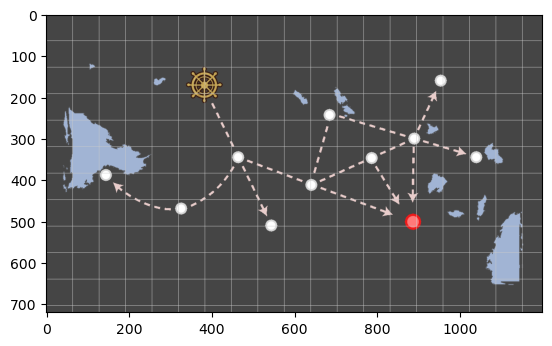

In [15]:
line_color = (0xCC, 0xCC, 0xCC)

img4 = cv2.line(img3, [0, 0], [0, 0], bound_color, 3)
for x in range(0, xywh["w"], 64):
    img4 = cv2.line(img4, [x, 0], [x, xywh["h"]], line_color, 1)

    
for y in range(0, xywh["h"], 64):
    img4 = cv2.line(img4, [0, y], [xywh["w"], y], line_color, 1)
plt.imshow(img4)
plt.show()